In [1]:
from __future__ import print_function
import PyPDF2
from PyPDF2 import PdfReader
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from nltk.translate.bleu_score import sentence_bleu

In [2]:
stemming = PorterStemmer()
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Open the PDF file in read-binary mode
def read_text(file_name):
    with open(file_name, 'rb') as file:
        # Create a PDF reader object
        reader = PdfReader(file)
        info = reader.metadata
        all_text=""
        # Get the number of pages in the PDF file
        num_pages = len(reader.pages)

        # Loop through all the pages and extract the text
        for i in range(num_pages):
            # Get the page object
            page =  reader.pages[i]

            # Extract the text from the page
            text= page.extract_text()
            all_text+=text
            # Print the text
    return str(all_text),info
    x,y = read_text("files/1-s2.0-S0090429518305971-main.pdf")



In [4]:
x,y = read_text("files/1-s2.0-S0090429518305971-main.pdf")


In [5]:
print(y)

{'/AuthoritativeDomain[1]': 'sciencedirect.com', '/Keywords': '', '/Title': 'Predictive Analytics and Modeling Employing Machine Learning Technology: The Next Step in Data Sharing, Analysis, and Individualized Counseling Explored With a Large, Prospective Prenatal Hydronephrosis Database', '/robots': 'noindex', '/Producer': 'Acrobat Distiller 10.1.13 (Windows)', '/CrossmarkDomainExclusive': 'true', '/ModDate': "D:20181225134835+05'30'", '/CrossMarkDomains[1]': 'sciencedirect.com', '/Author': 'Armando J. Lorenzo', '/CrossmarkMajorVersionDate': '2010-04-23', '/AuthoritativeDomain[2]': 'elsevier.com', '/Subject': 'Urology, 123 (2018) 204-209. doi:10.1016/j.urology.2018.05.041', '/ElsevierWebPDFSpecifications': '6.5', '/CreationDate': "D:20181219210605+05'30'", '/doi': '10.1016/j.urology.2018.05.041', '/CrossMarkDomains[2]': 'elsevier.com', '/Creator': 'Elsevier'}


{'/AuthoritativeDomain[1]': 'sciencedirect.com', '/Keywords': '', '/Title': 'Predictive Analytics and Modeling Employing Machine Learning Technology: The Next Step in Data Sharing, Analysis, and Individualized Counseling Explored With a Large, Prospective Prenatal Hydronephrosis Database', '/robots': 'noindex', '/Producer': 'Acrobat Distiller 10.1.13 (Windows)', '/CrossmarkDomainExclusive': 'true', '/ModDate': "D:20181225134835+05'30'", '/CrossMarkDomains[1]': 'sciencedirect.com', '/Author': 'Armando J. Lorenzo', '/CrossmarkMajorVersionDate': '2010-04-23', '/AuthoritativeDomain[2]': 'elsevier.com', '/Subject': 'Urology, 123 (2018) 204-209. doi:10.1016/j.urology.2018.05.041', '/ElsevierWebPDFSpecifications': '6.5', '/CreationDate': "D:20181219210605+05'30'", '/doi': '10.1016/j.urology.2018.05.041', '/CrossMarkDomains[2]': 'elsevier.com', '/Creator': 'Elsevier'}


In [6]:
stops = set(stopwords)                  

def remove_stops(text):
    meaningful_words_new=[]
    i=0
    meaningful_words = [w for w in text if (not w in stops)]
    for i in range(len(meaningful_words)-1):
        if len(meaningful_words[i])>1:
            meaningful_words_new.append(meaningful_words[i])
    return (meaningful_words_new)



In [7]:
def tokenize_and_stem(text):
    stops = set(stopwords) 
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.isalpha()]
    tokens=[w for w in tokens if (not w in stops)&(len(w)>1) ]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemming.stem(t) for t in filtered_tokens]
    
    return stems
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)if word.isalpha()]
    tokens=[w for w in tokens if (not w in stops)&(len(w)>1) ]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    
    return filtered_tokens

In [8]:
file = [file for file in os.listdir("files")]
file

['1-s2.0-S0090429518305971-main.pdf',
 '1-s2.0-S0302283818307401-main.pdf',
 '1-s2.0-S258893112300038X-main.pdf',
 '10.1007@s00345-019-03000-5.pdf',
 'abbod2007.pdf',
 'AI and reproductive.pdf',
 'Cancer Science - 2022 - Iwamura - Machine learning diagnosis by immunoglobulin N‐glycan signatures for precision diagnosis.pdf',
 'cci.18.00080.pdf',
 'doyle2021.pdf',
 'HBP.pdf',
 'HBP².pdf',
 'icu-61-239.pdf',
 'reproductive AI.pdf',
 's12911-021-01585-9.pdf',
 's41585-020-0312-1.pdf',
 'teichmann2007.pdf',
 'tju-46-supplement1-s27.pdf',
 'urolithiasis and AI.pdf',
 'wollin1998 (1).pdf',
 'wollin1998.pdf']

In [9]:
dic = {}
dic_tokenize ={}
infos={}
for i in range(len(file)):
    dic[file[i]],info = read_text("files/"+file[i])
    infos[i] = info


    

In [10]:
infos[0].author

'Armando J. Lorenzo'

In [11]:
author = []
title = []
subject = []
Id = []
creator = []
for i in range(len(infos)):
    author.append(infos[i].author)
    title.append(infos[i].title)
    subject.append(infos[i].subject)
    creator.append(infos[i].creator)
    Id.append(i)
    

In [12]:

from __future__ import print_function
from PyPDF2 import PdfReader
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from nltk.translate.bleu_score import sentence_bleu
from typing import List, Dict


class PDFReader():

    global pdf_dictionary 

    def __init__(self,directory :str) -> None:
        self.directory = directory
        self.pdfs_names = [pdf for pdf in os.listdir(directory)]
        self.pdf_dictionary = {}
        self.infos = {}
    
    # Open the PDF file in read-binary mode
    def read_text(self) -> str:
        
        
        for j in range(len(self.pdfs_names)):
            with open(self.directory + "/" +self.pdfs_names[j], 'rb') as file:
                # Create a PDF reader object
                reader = PdfReader(file)
                self.infos[j] = reader.metadata
                all_text=""
                # Get the number of pages in the PDF file
                num_pages = len(reader.pages)

                # Loop through all the pages and extract the text
                for i in range(num_pages):
                    # Get the page object
                    page =  reader.pages[i]
                    # Extract the text from the page
                    text= page.extract_text()
                    all_text+=text
                    # Print the text
                self.pdf_dictionary[self.pdfs_names[j]]= all_text
        return self.pdf_dictionary,self.infos
        

class TextPrecessor():
    
    def __init__(self) -> None:
        self.stemming = PorterStemmer()
        self.stopwords = set(nltk.corpus.stopwords.words("english"))
        self.data = pd.DataFrame({
            "text": [],
            "titre": [],
            "tokenize_text":[],
            "Author" : [],
            "subject" : [],
            "Id" : [],
            "Creator" : [],
            "title" : [],
            })
        self.preprocess_data()


    def tokenize_and_stem(self,text) -> list:
        # Call the read_text method to get the dictionary of PDF content
        tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.isalpha()]
        tokens=[w for w in tokens if (not w in self.stopwords)&(len(w)>1) ]
        filtered_tokens = []
            # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)
        stems = [self.stemming.stem(t) for t in filtered_tokens]
        return stems

    def preprocess_data(self):
        # Call the tokenize_and_stem method to tokenize and stem the PDF content
        pdf_reader = PDFReader("files")
        pdf_dictionary,infos = pdf_reader.read_text()
        for i, pdf_name in enumerate(pdf_dictionary.keys()):
            
            # Append the data to the DataFrame
            self.data = self.data.append({
                "text": pdf_dictionary[pdf_name],
                "titre": pdf_name,
                "tokenize_text": self.tokenize_and_stem(pdf_dictionary[pdf_name]),
                "Author" : infos[i].author ,
                "subject" : infos[i].subject,
                "Id" : i+1,
                "Creator" : infos[i].creator,
                "title" : infos[i].title,
            }, ignore_index=True)
        self.data.fillna("Unkown").replace("","Unknown")

In [13]:
instance = TextPrecessor()
instance.data

C:\Users\ASUS\AppData\Local\Temp\ipykernel_116292\647506.py:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data = self.data.append({
C:\Users\ASUS\AppData\Local\Temp\ipykernel_116292\647506.py:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data = self.data.append({
C:\Users\ASUS\AppData\Local\Temp\ipykernel_116292\647506.py:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data = self.data.append({
C:\Users\ASUS\AppData\Local\Temp\ipykernel_116292\647506.py:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.data = self.data.append({
C:\Users\ASUS\AppData\Local\Temp\ipykernel_116292\647506.py:93: FutureWarning: T

,text,titre,tokenize_text,Author,subject,Id,Creator,title
0,Pediatric Urology\nPredictive Analytics and Mo...,1-s2.0-S0090429518305971-main.pdf,"[pediatr, urolog, predict, analyt, model, empl...",Armando J. Lorenzo,"Urology, 123 (2018) 204-209. doi:10.1016/j.uro...",1.0,Elsevier,Predictive Analytics and Modeling Employing Ma...
1,Platinum Priority –Prostate Cancer –Editor ’s ...,1-s2.0-S0302283818307401-main.pdf,"[platinum, prioriti, cancer, choic, editori, p...",Gregory B. Auffenberg,"European Urology, 75 (2019) 901-907. doi:10.10...",2.0,Elsevier,askMUSIC: Leveraging a Clinical Registry to De...
2,Development and External Validation of a Machi...,1-s2.0-S258893112300038X-main.pdf,"[develop, extern, valid, machin, learn, model,...",Ali Sabbagh,"European Urology Oncology, Corrected proof. do...",3.0,Elsevier,Development and External Validation of a Machi...
3,Vol.:(0123456789)1 3World Journal of Urology \...,10.1007@s00345-019-03000-5.pdf,"[vol, journal, urolog, http, topic, paper, cur...",Rodrigo Suarez-Ibarrola,"World Journal of Urology, https://doi.org/10.1...",4.0,Springer,Current and future applications of machine and...
4,Application of Artiﬁcial Intelligence\nto the ...,abbod2007.pdf,"[applic, artiﬁci, intellig, manag, urolog, can...",,,5.0,Elsevier,doi:10.1016/j.juro.2007.05.122
5,"MEN'S HEALTH (A DABAJA, SECTION EDITOR)\nArtif...",AI and reproductive.pdf,"[men, health, dabaja, section, editor, artific...",Kevin Y. Chu; Daniel E. Nassau; Himanshu Arora...,"Curr Urol Rep, doi:10.1007/s11934-019-0914-4",6.0,Arbortext Advanced Print Publisher 9.1.440/W U...,Artificial Intelligence in Reproductive Urology
6,2434 | Cancer Science. 2022;113:2434–2445...,Cancer Science - 2022 - Iwamura - Machine lear...,"[cancer, scienc, march, revis, april, accept, ...",None,Cancer Science 2022.113:2434-2445,7.0,Adobe InDesign 15.0 (Windows),Machine learning diagnosis by immunoglobulin N...
7,© 2018 by American Society of Clinical Oncolog...,cci.18.00080.pdf,"[american, societi, clinic, oncolog, clinic, c...","Sami-Ramzi Leyh-Bannurah, Zhe Tian, Pierre I. ...",JCO Clinical Cancer Informatics 2018.:1-9,8.0,Adobe InDesign CC 13.0 (Windows),Deep Learning for Natural Language Processing ...
8,Vol.:(0123456789)1 3World Journal of Urology \...,doyle2021.pdf,"[vol, journal, urolog, http, topic, paper, mac...",Patrick W. Doyle,"World Journal of Urology, https://doi.org/10.1...",9.0,Springer,Machine learning applications to enhance patie...
9,c o m p u t e r m e t h o d s a...,HBP.pdf,"[jo, ur, nal, ho, ag, hybrid, base, intellig, ...",Abolfazl Doostparast Torshizi,"Computer Methods and Programs in Biomedicine, ...",10.0,Elsevier,A hybrid fuzzy-ontology based intelligent syst...


In [14]:
data = {
  "text": [item for item in dic.values()],
  "titre": file,
  "similarity":[0 for i in range(len(file))],
  "Author" : author,
  "subject" : subject,
  "Id" : Id,
  "Creator" : creator,
  "title" : title,
}
#load data into a DataFrame object:
data= pd.DataFrame(data)

In [15]:
data.fillna("Unkown").replace("","Unknown")


,text,titre,similarity,Author,subject,Id,Creator,title
0,Pediatric Urology\nPredictive Analytics and Mo...,1-s2.0-S0090429518305971-main.pdf,0,Armando J. Lorenzo,"Urology, 123 (2018) 204-209. doi:10.1016/j.uro...",0,Elsevier,Predictive Analytics and Modeling Employing Ma...
1,Platinum Priority –Prostate Cancer –Editor ’s ...,1-s2.0-S0302283818307401-main.pdf,0,Gregory B. Auffenberg,"European Urology, 75 (2019) 901-907. doi:10.10...",1,Elsevier,askMUSIC: Leveraging a Clinical Registry to De...
2,Development and External Validation of a Machi...,1-s2.0-S258893112300038X-main.pdf,0,Ali Sabbagh,"European Urology Oncology, Corrected proof. do...",2,Elsevier,Development and External Validation of a Machi...
3,Vol.:(0123456789)1 3World Journal of Urology \...,10.1007@s00345-019-03000-5.pdf,0,Rodrigo Suarez-Ibarrola,"World Journal of Urology, https://doi.org/10.1...",3,Springer,Current and future applications of machine and...
4,Application of Artiﬁcial Intelligence\nto the ...,abbod2007.pdf,0,Unknown,Unknown,4,Elsevier,doi:10.1016/j.juro.2007.05.122
5,"MEN'S HEALTH (A DABAJA, SECTION EDITOR)\nArtif...",AI and reproductive.pdf,0,Kevin Y. Chu; Daniel E. Nassau; Himanshu Arora...,"Curr Urol Rep, doi:10.1007/s11934-019-0914-4",5,Arbortext Advanced Print Publisher 9.1.440/W U...,Artificial Intelligence in Reproductive Urology
6,2434 | Cancer Science. 2022;113:2434–2445...,Cancer Science - 2022 - Iwamura - Machine lear...,0,Unkown,Cancer Science 2022.113:2434-2445,6,Adobe InDesign 15.0 (Windows),Machine learning diagnosis by immunoglobulin N...
7,© 2018 by American Society of Clinical Oncolog...,cci.18.00080.pdf,0,"Sami-Ramzi Leyh-Bannurah, Zhe Tian, Pierre I. ...",JCO Clinical Cancer Informatics 2018.:1-9,7,Adobe InDesign CC 13.0 (Windows),Deep Learning for Natural Language Processing ...
8,Vol.:(0123456789)1 3World Journal of Urology \...,doyle2021.pdf,0,Patrick W. Doyle,"World Journal of Urology, https://doi.org/10.1...",8,Springer,Machine learning applications to enhance patie...
9,c o m p u t e r m e t h o d s a...,HBP.pdf,0,Abolfazl Doostparast Torshizi,"Computer Methods and Programs in Biomedicine, ...",9,Elsevier,A hybrid fuzzy-ontology based intelligent syst...


In [16]:
x= data["Cluster"]
x

KeyError: 'Cluster'

In [17]:
#define vectorizer parameters
data = data.reset_index(drop=True)
tfidf_vectorizer = TfidfVectorizer(max_features=200,
                                 stop_words= stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem)

tfidf_matrix = tfidf_vectorizer.fit_transform(data["text"]) 

c:\Users\ASUS\anaconda3\envs\projet_s8\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\projet_s8\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [91]:
print(tfidf_matrix)

  (0, 55)	0.09501025342187114
  (0, 111)	0.042072211329677485
  (0, 98)	0.11569858115661309
  (0, 57)	0.024645665575136762
  (0, 34)	0.016858959916441155
  (0, 13)	0.010001732175881075
  (0, 80)	0.010518052832419371
  (0, 169)	0.009518746457391829
  (0, 164)	0.019037492914783658
  (0, 53)	0.008637295765624648
  (0, 40)	0.02855623937217549
  (0, 126)	0.016858959916441155
  (0, 28)	0.017274591531249297
  (0, 191)	0.07252040890993754
  (0, 47)	0.021036105664838742
  (0, 100)	0.0400069287035243
  (0, 102)	0.038074985829567316
  (0, 76)	0.008637295765624648
  (0, 176)	0.009518746457391829
  (0, 182)	0.027195153341226578
  (0, 51)	0.023343334759638422
  (0, 38)	0.009518746457391829
  (0, 35)	0.010518052832419371
  (0, 42)	0.013036103790075637
  (0, 187)	0.011671667379819211
  :	:
  (18, 90)	0.18331109204505408
  (18, 148)	0.07082045188832757
  (18, 84)	0.06504992720216958
  (18, 112)	0.11568636860169075
  (18, 91)	0.16792313928274483
  (18, 49)	0.20671250805080565
  (18, 4)	0.003077635957386

In [18]:
terms=tfidf_vectorizer.get_feature_names_out()

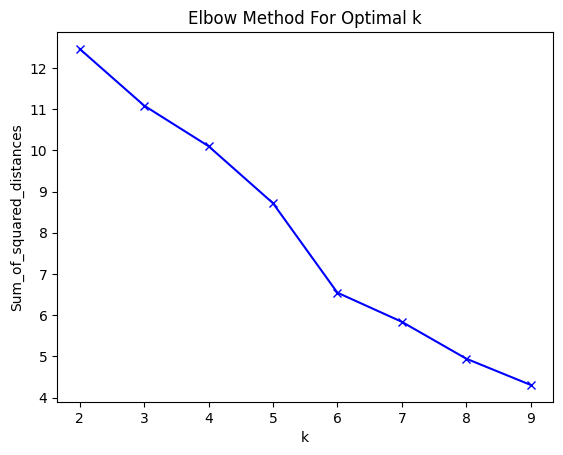

In [19]:
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=1000, n_init=1,random_state=42,verbose=0)
    km = km.fit(tfidf_matrix)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [20]:
def find_best_clusters(data, max_clusters=len(file)):
    best_score = -1
    best_k = 0
    for k in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=1, random_state=42,verbose=0)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        if score > best_score:
            best_score = score
            best_k = k
    return best_k


In [21]:
nbr_cluster=find_best_clusters(tfidf_matrix)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_116292\1789472525.py:6: ConvergenceWarning: Number of distinct clusters (19) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  kmeans.fit(data)


In [22]:

model = KMeans(n_clusters=nbr_cluster, init='k-means++', 
            max_iter=100, n_init=1, verbose=0, random_state=42)

model.fit_transform(tfidf_matrix)
model.fit(tfidf_matrix)

KMeans(max_iter=100, n_init=1, random_state=42)

In [23]:
data['Cluster'] = model.labels_

In [24]:
clusters = KMeans(n_clusters=nbr_cluster, max_iter=200, n_init=1,random_state=42,verbose=0).fit_predict(tfidf_matrix)

In [25]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in data["text"]:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [26]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [27]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(nbr_cluster):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :100]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print()

Top terms per cluster:

Cluster 0 words: glycan, specifically, scored, detected, bca, disease, cancer, urology, auc, using, respectively, bph, et, et, sensitivity, cell, prostate, datasets, al, https, diagnostic, tract, prostate, urinary, value, lower, bladder, analysis, ml, carcinoma, renal, patient, medicine, article, data, shows, bladder, could, also, benign, roc, tumors, system, university, psa, predictive, learning, diagnosis, study, total, cases, results, machine, validating, applications, modeling, several, machine, evaluated, accuracy, pathologic, combining, important, therapy, difference, classify, status, clinical, research, information, need, approaches, identify, selected, staging, represent, patterns, authors, time, high, based, require, groups, treatments, table, reporting, med, supporting, training, improve, number, tests, biopsy, included, outcome, medical, available, two, obtained, risk,
Cluster 1 words: predictive, et, using, et, patient, ml, al, data, ann, modeling, 

In [28]:
cluster = {}
for i in range(nbr_cluster):
    print("Cluster %d:" % i)
    cluster[i] = []  # create a new list for each cluster
    for ind in order_centroids[i, :100]:
        cluster[i].append(terms[ind])
        print(' %s' % terms[ind])

Cluster 0:
 glycan
 specif
 score
 detect
 bca
 diseas
 cancer
 urolog
 auc
 use
 respect
 bph
 et
 et al
 sensit
 cell
 prostat
 dataset
 al
 http
 diagnost
 tract
 prostat cancer
 urinari
 valu
 lower
 bladder cancer
 analysi
 ml
 carcinoma
 renal
 patient
 medicin
 articl
 data
 show
 bladder
 could
 also
 benign
 roc
 tumor
 system
 univers
 psa
 predict
 learn
 diagnosi
 studi
 total
 case
 result
 machin
 valid
 applic
 model
 sever
 machin learn
 evalu
 accuraci
 patholog
 combin
 import
 therapi
 differ
 classifi
 statu
 clinic
 research
 inform
 need
 approach
 identifi
 select
 stage
 repres
 pattern
 author
 time
 high
 base
 requir
 group
 treatment
 tabl
 report
 med
 support
 train
 improv
 number
 test
 biopsi
 includ
 outcom
 medic
 avail
 two
 obtain
 risk
Cluster 1:
 predict
 et
 use
 et al
 patient
 ml
 al
 data
 ann
 model
 stone
 imag
 cancer
 learn
 urolog
 renal
 machin
 network
 algorithm
 ai
 accuraci
 neural
 clinic
 prostat
 svm
 system
 studi
 surgic
 artifi

In [55]:
import re
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet


query = "(xgboost or fragmentation) "

# define a dictionary of synonyms
synonyms = {}
for term in re.findall(r'\b\w+\b', query):
    synonyms[term] = set()
    for syn in wordnet.synsets(term):
        for lemma in syn.lemmas():
            synonyms[term].add(lemma.name())

or_keywords = [k.strip() for k in query.split("and")]
and_keywords = []
for match in re.findall(r'\((.*?)\)|(\b\w+\b)|(\b(or)\b)|(\b(and)\b)', query):
    keyword = "".join([x for x in match if x]).strip().lower()
    if keyword:
        if keyword != "or" and "or" in keyword:
            and_keywords.append([[PorterStemmer().stem(w.strip().lower())]+list(synonyms.get(w.strip().lower(), set())) for w in keyword.split("or")])
        elif keyword != "and" and "and" in keyword:
            and_keywords.append([[PorterStemmer().stem(w.strip().lower())]+list(synonyms.get(w.strip().lower(), set())) for w in keyword.split("and")])
        else:
            and_keywords.append([[PorterStemmer().stem(keyword)]+list(synonyms.get(keyword, set()))])

and_keywords = [x for x in and_keywords if  x != [['or']] and x!=[['and']]]

for i in range(len(data["text"])):
    matches = []
    if len(or_keywords) == 1:
        k = or_keywords[0]
        or_matches = []
        for w in k.split("or"):
            found = any([t in str(PorterStemmer().stem(data["text"][i].lower())) for t in and_keywords[0]])
            or_matches.append(found)
        matches.append(any(or_matches))
    elif len(and_keywords) == 1:
        k = and_keywords[0]
        and_matches = []
        for w in k:
            found = any([t in str(PorterStemmer().stem(data["text"][i].lower())) for t in w])
            and_matches.append(found)
        matches.append(all(and_matches))
    else:
        for k in and_keywords:
            or_matches = []
            for w in k:
                found = any([t in str(PorterStemmer().stem(data["text"][i].lower())) for t in w])
                or_matches.append(found)
            matches.append(any(or_matches))
        #matches = [m for m in matches if m]
 
    if all(matches):
        print("Match found! at pdf",data["titre"][i])
    else:
        print("No match found at pdf",data["titre"][i])
    print(matches)

TypeError: 'in <string>' requires string as left operand, not list

In [76]:
import re
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet

query = "(xgboost or fragmentation) and sperm and nephrolithiasis "

# define a dictionary of synonyms
synonyms = {}
for term in re.findall(r'\b\w+\b', query):
    synonyms[term] = set()
    for syn in wordnet.synsets(term):
        for lemma in syn.lemmas():
            synonyms[term].add(lemma.name())

or_keywords = [k.strip() for k in query.split("and")]
and_keywords = []
for match in re.findall(r'\((.*?)\)|(\b\w+\b)|(\b(or)\b)|(\b(and)\b)', query):
    keyword = "".join([x for x in match if x]).strip().lower()
    if keyword:
        if keyword != "or" and "or" in keyword:
            and_keywords.append([[PorterStemmer().stem(w.strip().lower())]+list(synonyms.get(w.strip().lower(), set())) for w in keyword.split("or")])
        elif keyword != "and" and "and" in keyword:
            and_keywords.append([[PorterStemmer().stem(w.strip().lower())]+list(synonyms.get(w.strip().lower(), set())) for w in keyword.split("and")])
        else:
            and_keywords.append([[PorterStemmer().stem(keyword)]+list(synonyms.get(keyword, set()))])

and_keywords = [x for x in and_keywords if x != [['or']] and not any('or' in sublist for sublist in x) and x != [['and']] and not any('and' in sublist for sublist in x)]

print(and_keywords)
print(or_keywords)
for i in range(len(data["text"])):
    matches = []
    for or_keywords_group in or_keywords:
        or_matches = []
        for and_keywords_group in and_keywords:
            and_matches = []
            for keyword_set in and_keywords_group:
                print(keyword_set)
                found = any([str(t) in PorterStemmer().stem(data["text"][i].lower()) for t in keyword_set])
                and_matches.append(found)
            or_matches.append(all(and_matches))
        matches.append(any(or_matches))

    if all(matches):
        print("Match found! at pdf", data["titre"][i])
        print(matches)
    else:
        print("No match found at pdf", data["titre"][i])
        print(matches)




[[['xgboost'], ['fragment', 'atomization', 'fragmentation', 'atomisation']], [['sperm', 'spermatozoan', 'spermatozoon', 'sperm', 'sperm_cell']], [['nephrolithiasi', 'nephrolithiasis', 'renal_lithiasis']]]
['(xgboost or fragmentation)', 'sperm', 'nephrolithiasis']
['xgboost']
['fragment', 'atomization', 'fragmentation', 'atomisation']
['sperm', 'spermatozoan', 'spermatozoon', 'sperm', 'sperm_cell']
['nephrolithiasi', 'nephrolithiasis', 'renal_lithiasis']
['xgboost']
['fragment', 'atomization', 'fragmentation', 'atomisation']
['sperm', 'spermatozoan', 'spermatozoon', 'sperm', 'sperm_cell']
['nephrolithiasi', 'nephrolithiasis', 'renal_lithiasis']
['xgboost']
['fragment', 'atomization', 'fragmentation', 'atomisation']
['sperm', 'spermatozoan', 'spermatozoon', 'sperm', 'sperm_cell']
['nephrolithiasi', 'nephrolithiasis', 'renal_lithiasis']
No match found at pdf 1-s2.0-S0090429518305971-main.pdf
[False, False, False]
['xgboost']
['fragment', 'atomization', 'fragmentation', 'atomisation']
['sp

In [86]:
import re
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet

query = " xgboost or urology"
# define a dictionary of synonyms
synonyms = {}
for term in re.findall(r'\b\w+\b', query):
    synonyms[term] = set()
    for syn in wordnet.synsets(term):
        for lemma in syn.lemmas():
            synonyms[term].add(lemma.name())

or_keywords = [k.strip() for k in query.split("and")]
and_keywords = []
for match in re.findall(r'\((.*?)\)|(\b\w+\b)|(\b(or)\b)|(\b(and)\b)', query):
    keyword = "".join([x for x in match if x]).strip().lower()
    if keyword:
        if keyword != "or" and "or" in keyword:
            and_keywords.append([[PorterStemmer().stem(w.strip().lower())]+list(synonyms.get(w.strip().lower(), set())) for w in keyword.split("or")])
        elif keyword != "and" and "and" in keyword:
            and_keywords.append([[PorterStemmer().stem(w.strip().lower())]+list(synonyms.get(w.strip().lower(), set())) for w in keyword.split("and")])
        else:
            and_keywords.append([[PorterStemmer().stem(keyword)]+list(synonyms.get(keyword, set()))])

and_keywords = [x for x in and_keywords if x != [['or']] and not any('or' in sublist for sublist in x) and x != [['and']] and not any('and' in sublist for sublist in x)]
for i in range(len(data["text"])):
    matches = []
    if len(or_keywords) == 1:
        k = or_keywords[0]
        or_matches = []
        for w in k.split("or"):
            found = any([t in str(PorterStemmer().stem(data["text"][i].lower())) for t in and_keywords[0][0]])
            or_matches.append(found)
        matches.append(any(or_matches))
    elif len(and_keywords) == 1:
        k = and_keywords[0]
        and_matches = []
        for w in k:
            found = any([t in str(PorterStemmer().stem(data["text"][i].lower())) for t in w])
            and_matches.append(found)
        matches.append(all(and_matches))
    elif len(and_keywords) == 0:  # Single word query
        word = or_keywords[0]
        matches.append(word in str(PorterStemmer().stem(data["text"][i].lower())))
    else:
        for k in and_keywords:
            or_matches = []
            for w in k:
                found = any([t in str(PorterStemmer().stem(data["text"][i].lower())) for t in w])
                or_matches.append(found)
            matches.append(any(or_matches))
        # matches = [m for m in matches if m]
 
    if all(matches):
        print("Match found! at pdf",data["titre"][i])
    else:
        print("No match found at pdf",data["titre"][i])
    print(matches)


No match found at pdf 1-s2.0-S0090429518305971-main.pdf
[False]
No match found at pdf 1-s2.0-S0302283818307401-main.pdf
[False]
Match found! at pdf 1-s2.0-S258893112300038X-main.pdf
[True]
No match found at pdf 10.1007@s00345-019-03000-5.pdf
[False]
No match found at pdf abbod2007.pdf
[False]
No match found at pdf AI and reproductive.pdf
[False]
No match found at pdf Cancer Science - 2022 - Iwamura - Machine learning diagnosis by immunoglobulin N‐glycan signatures for precision diagnosis.pdf
[False]
No match found at pdf cci.18.00080.pdf
[False]
No match found at pdf doyle2021.pdf
[False]
No match found at pdf HBP.pdf
[False]
No match found at pdf HBP².pdf
[False]
No match found at pdf icu-61-239.pdf
[False]
Match found! at pdf reproductive AI.pdf
[True]
No match found at pdf s12911-021-01585-9.pdf
[False]
No match found at pdf s41585-020-0312-1.pdf
[False]
No match found at pdf teichmann2007.pdf
[False]
No match found at pdf tju-46-supplement1-s27.pdf
[False]
No match found at pdf uro

In [ ]:
for i in range(len(data["text"])):
    matches = []
    if len(or_keywords) == 1:
        k = or_keywords[0]
        or_matches = []
        for w in k.split("or"):
            found = any([PorterStemmer().stem(w.lower()) == str(t) for t in and_keywords[0]])
            or_matches.append(found)
        matches.append(any(or_matches))
    elif len(and_keywords) == 1:
        k = and_keywords[0]
        and_matches = []
        for w in k:
            found = any([PorterStemmer().stem(w.lower()) == str(t) for t in w])
            and_matches.append(found)
        matches.append(all(and_matches))
    else:
        for k in and_keywords:
            or_matches = []
            for w in k:
                found = any([PorterStemmer().stem(w.lower()) == str(t) for t in w])
                or_matches.append(found)
            matches.append(any(or_matches))
 
    if all(matches):
        print("Match found! at pdf", data["titre"][i])
    else:
        print("No match found at pdf", data["titre"][i])
    print(matches)


In [42]:
query = "xgboost or fragmentation "

# define a dictionary of synonyms
synonyms = {}
for term in re.findall(r'\b\w+\b', query):
    synonyms[term] = set()
    for syn in wordnet.synsets(term):
        for lemma in syn.lemmas():
            synonyms[term].add(lemma.name())

or_keywords = [k.strip() for k in query.split("and")]
and_keywords = []
for match in re.findall(r'\((.*?)\)|(\b\w+\b)|(\b(or)\b)|(\b(and)\b)', query):
    keyword = "".join([x for x in match if x]).strip().lower()
    if keyword:
        if keyword != "or" and "or" in keyword:
            and_keywords.append([[PorterStemmer().stem(w.strip().lower())]+list(synonyms.get(w.strip().lower(), set())) for w in keyword.split("or")])
        elif keyword != "and" and "and" in keyword:
            and_keywords.append([[PorterStemmer().stem(w.strip().lower())]+list(synonyms.get(w.strip().lower(), set())) for w in keyword.split("and")])
        else:
            and_keywords.append([[PorterStemmer().stem(keyword)]+list(synonyms.get(keyword, set()))])

and_keywords = [x for x in and_keywords if  x != [['or']] and x!=[['and']]]
and_keywords


[[['xgboost']],
 [['or',
   'operating_theatre',
   'operating_room',
   'Oregon',
   'surgery',
   'OR',
   'Beaver_State',
   'operating_theater']],
 [['fragment', 'atomization', 'fragmentation', 'atomisation']]]

In [30]:

# search for 1 word
search_word = "sperm"
# Using loops
counter = {key: 0 for key in cluster.keys()}

# Loop over each cluster and count occurrences of search_word
for key, value in cluster.items():
    for word in value:
        if str(word) == str(search_word):
            counter[key] += 1

# Print the counter for each cluster
for key, value in counter.items():
    print(f"{search_word} appears {value} times in cluster_{key}")



sperm appears 0 times in cluster_0
sperm appears 0 times in cluster_1
sperm appears 0 times in cluster_2
sperm appears 0 times in cluster_3
sperm appears 0 times in cluster_4
sperm appears 0 times in cluster_5
sperm appears 1 times in cluster_6
sperm appears 0 times in cluster_7


In [31]:
# search for 1 word
def search_one_word_cluster(word):
    search_word_list=tokenize_and_stem(word)
    # loop over each word serach
    for word_ in search_word_list:
        # Using loops
        counter = {key: 0 for key in cluster.keys()}

        # Loop over each cluster and count occurrences of search_word
        for key, value in cluster.items():
            for word in value:
                if str(word) == str(word_):
                    counter[key] += 1

        # Print the counter for each cluster
        for key, value in counter.items():
            print(f"{word_} appears {value} times in cluster_{key}")
            


In [ ]:
# search for 2 word
def search_words_cluster(text):
    
    search_word_list=tokenize_and_stem(text)
    #for i in range(len(search_word_list)):
        #search_word_list[i]=search_word_list[i].strip()# supprimer les escpaces
    # loop over each word serach
    for word_ in search_word_list:
        # Using loops
        counter = {key: 0 for key in cluster.keys()}

        # Loop over each cluster and count occurrences of search_word
        for key, value in cluster.items():
            for word in value:
                if str(word) == str(word_):
                    counter[key] += 1

        # Print the counter for each cluster
        for key, value in counter.items():
            print(f"{word_} appears {value} times in cluster_{key}")
        print("/////////////////////////////")        


In [ ]:
search_one_word_cluster("sperm")

sperm appears 0 times in cluster_0
sperm appears 0 times in cluster_1
sperm appears 0 times in cluster_2
sperm appears 0 times in cluster_3
sperm appears 0 times in cluster_4
sperm appears 0 times in cluster_5
sperm appears 1 times in cluster_6
sperm appears 0 times in cluster_7


In [ ]:
#evaluators
print("Homogeneity: %0.3f" % metrics.homogeneity_score(data["text"], data['Cluster']))
print("Completeness: %0.3f" % metrics.completeness_score(data["text"], data['Cluster']))
print("V-measure: %0.3f" % metrics.v_measure_score(data["text"], data["Cluster"]))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(data["text"], data["Cluster"]))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(tfidf_matrix,data["Cluster"] , sample_size=1000))


Homogeneity: 0.612
Completeness: 1.000
V-measure: 0.759
Adjusted Rand-Index: 0.047
Silhouette Coefficient: 0.164


In [ ]:

candidate = "sperm"
for i in range(0,5):
    score = sentence_bleu(cluster[i], candidate, weights=(0.25, 0.25, 0.25, 0.25))
    
    print(score)
print("\n")
for i in range(0,10):
    score = sentence_bleu(data["tokenize_text"][i],candidate,weights=(0.25,0.25,0.25,0.25))
    print(score)

9.280167055464391e-78
1.1036040690772268e-77
1.1036040690772268e-77
1.1036040690772268e-77
8.636168555094496e-78




c:\Users\ma.jari\.conda\envs\salle_IA\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


KeyError: 'tokenize_text'

In [87]:

def tf_idf_similarity(text,data):
# Recherche d'articles similaires
    query = text
    query_tfidf = tfidf_vectorizer.transform([query])
    similarity_scores = cosine_similarity(query_tfidf, tfidf_matrix)

    # Classement des articles par ordre décroissant de similarité
    similarity_scores = similarity_scores[0][np.argsort(data.index)]
    data['similarity'] = list(similarity_scores)
    # Sort the dataframe by document ID or title
    data = data.sort_values('titre')

    # Reset the index to ensure that the order of the documents is always the same
    data = data.reset_index(drop=True)
    index_max=int(np.argmax(data["similarity"]))
    cluster_index_max=data["Cluster"][index_max]
    # Affichage des articles similaires
    print(data.loc[data["Cluster"]==cluster_index_max,["titre","similarity","Cluster"]].sort_values(["similarity"],ascending=False))

In [89]:
tf_idf_similarity("aefe",data)

                                titre  similarity  Cluster
0   1-s2.0-S0090429518305971-main.pdf         0.0        1
3      10.1007@s00345-019-03000-5.pdf         0.0        1
8                       abbod2007.pdf         0.0        1
10                      doyle2021.pdf         0.0        1
11                     icu-61-239.pdf         0.0        1
13             s12911-021-01585-9.pdf         0.0        1
16         tju-46-supplement1-s27.pdf         0.0        1
17            urolithiasis and AI.pdf         0.0        1


In [ ]:
import re

# Exemple de requête
query = "(xgboost or surgic) and sperm"

# Identifier les groupes de mots clés associés à chaque opérateur booléen
or_groups = re.findall(r'\([^()]* or [^()]*\)', query)
and_groups = re.findall(r'and', query)

# Rechercher chaque groupe de mots clés, en utilisant la logique booléenne pour combiner les résultats
for i in range(len(data["text"])):
    matches = []
    for group in or_groups:
        keywords = [k.strip().lower() for k in group[1:-1].split("or")]
        found = any(all(word.strip().lower() in str(data["text"][i]).lower() for word in keywords) for i in range(len(data["text"])))
        matches.append(found)
        
    for group in and_groups:
        keywords = [k.strip().lower() for k in group[1:-1].split("and")]
        found = all(any(word.strip().lower() in str(data["text"][i]).lower() for word in keywords) for i in range(len(data["text"])))
        matches.append(found)
        
    if any(matches):
            print("Match found! at pdf",data["titre"][i])
    else:
            print("No match found at pdf",data["titre"][i])

Match found! at pdf 1-s2.0-S0090429518305971-main.pdf
Match found! at pdf 1-s2.0-S0302283818307401-main.pdf
Match found! at pdf 1-s2.0-S258893112300038X-main.pdf
Match found! at pdf 10.1007@s00345-019-03000-5.pdf
Match found! at pdf abbod2007.pdf
Match found! at pdf AI and reproductive.pdf
Match found! at pdf Cancer Science - 2022 - Iwamura - Machine learning diagnosis by immunoglobulin N‐glycan signatures for precision diagnosis.pdf
Match found! at pdf cci.18.00080.pdf
Match found! at pdf doyle2021.pdf
Match found! at pdf HBP.pdf
Match found! at pdf HBP².pdf
Match found! at pdf icu-61-239.pdf
Match found! at pdf reproductive AI.pdf
Match found! at pdf s12911-021-01585-9.pdf
Match found! at pdf s41585-020-0312-1.pdf
Match found! at pdf teichmann2007.pdf
Match found! at pdf tju-46-supplement1-s27.pdf
Match found! at pdf urolithiasis and AI.pdf
Match found! at pdf wollin1998 (1).pdf
Match found! at pdf wollin1998.pdf


In [ ]:
import re

query = "(xgboost or surgic )and sperm"

# extract keywords with parentheses
keywords = re.findall(r'\((.*?)\)|\b\w+\b', query)
keywords = [k.strip().lower() for k in keywords if k.strip()]

# handle OR and AND operators
i = 0
while i < len(keywords):
    if keywords[i] == "or":
        keywords[i-1:i+2] = [keywords[i-1] + " or " + keywords[i+1]]
    elif keywords[i] == "and":
        keywords[i-1:i+2] = [keywords[i-1] + " and " + keywords[i+1]]
    else:
        i += 1

# search for matches
for i in range(len(data["text"])):
    matches = []
    for k in keywords:
        if "and" in k:
            and_keywords = k.split("and")
            found = all(word.strip().lower() in str(data["text"][i]).lower() for word in and_keywords)
            matches.append(found)
        elif "or" in k:
            or_keywords = k.split("or")
            found = any(word.strip().lower() in str(data["text"][i]).lower() for word in or_keywords)
            matches.append(found)
        else:
            found = k.strip() in str(data["text"][i]).lower()
            matches.append(found)
            
    if any(matches):
        print("Match found! at pdf ",data["titre"][i])
    else:
        print("No match found at",data["titre"][i])


Match found! at pdf  1-s2.0-S0090429518305971-main.pdf
Match found! at pdf  1-s2.0-S0302283818307401-main.pdf
Match found! at pdf  1-s2.0-S258893112300038X-main.pdf
Match found! at pdf  10.1007@s00345-019-03000-5.pdf
No match found at abbod2007.pdf
Match found! at pdf  AI and reproductive.pdf
No match found at Cancer Science - 2022 - Iwamura - Machine learning diagnosis by immunoglobulin N‐glycan signatures for precision diagnosis.pdf
Match found! at pdf  cci.18.00080.pdf
Match found! at pdf  doyle2021.pdf
Match found! at pdf  HBP.pdf
No match found at HBP².pdf
No match found at icu-61-239.pdf
Match found! at pdf  reproductive AI.pdf
Match found! at pdf  s12911-021-01585-9.pdf
Match found! at pdf  s41585-020-0312-1.pdf
Match found! at pdf  teichmann2007.pdf
Match found! at pdf  tju-46-supplement1-s27.pdf
Match found! at pdf  urolithiasis and AI.pdf
No match found at wollin1998 (1).pdf
No match found at wollin1998.pdf


In [ ]:
import re
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet

query = "xgboost"
result = []
# define a dictionary of synonyms
synonyms = {}
for term in re.findall(r'\b\w+\b', query):
    synonyms[term] = set()
    for syn in wordnet.synsets(term):
        for lemma in syn.lemmas():
            synonyms[term].add(lemma.name())

or_keywords = [k.strip() for k in query.split("and")]
and_keywords = []
for match in re.findall(r'\((.*?)\)|(\b\w+\b)|(\b(or)\b)|(\b(and)\b)', query):
    keyword = "".join([x for x in match if x]).strip().lower()
    if keyword:
        if keyword != "or" and "or" in keyword:
            and_keywords.append([[PorterStemmer().stem(w.strip().lower())]+list(synonyms.get(w.strip().lower(), set())) for w in keyword.split("or")])
        elif keyword != "and" and "and" in keyword:
            and_keywords.append([[PorterStemmer().stem(w.strip().lower())]+list(synonyms.get(w.strip().lower(), set())) for w in keyword.split("and")])
        else:
            and_keywords.append([[PorterStemmer().stem(keyword)]+list(synonyms.get(keyword, set()))])

and_keywords = [x for x in and_keywords if  x != [['or']] and x!=[['and']]]

for i in range(len(data["text"])):
    matches = []
    if len(or_keywords) == 1:
        k = or_keywords[0]
        or_matches = []
        for w in k.split("or"):
            stemmed_text = [PorterStemmer().stem(word.lower()) for word in data["text"][i].split()]
            found = any([t in stemmed_text for t in and_keywords[0]])
            or_matches.append(found)
        matches.append(any(or_matches))
    elif len(and_keywords) == 1:
        k = and_keywords[0]
        and_matches = []
        for w in k:
            found = any([t in str(PorterStemmer().stem(data["text"][i].lower())) for t in w])
            and_matches.append(found)
        matches.append(all(and_matches))
    else:
        for k in and_keywords:
            or_matches = []
            for w in k:
                found = any([t in str(PorterStemmer().stem(data["text"][i].lower())) for t in w])
                or_matches.append(found)
            matches.append(any(or_matches))
        #matches = [m for m in matches if m]
 
    if all(matches):
       result.append(data["titre"][i])
    
        
    """ else:
        print("No match found at pdf",data["titre"][i])
    print(matches) """
print(result)

[]


In [ ]:
import re
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet

query = "sperm"

# define a dictionary of synonyms
synonyms = {}
for term in re.findall(r'\b\w+\b', query):
    synonyms[term] = set()
    for syn in wordnet.synsets(term):
        for lemma in syn.lemmas():
            synonyms[term].add(lemma.name())

or_keywords = [k.strip() for k in query.split("and")]
and_keywords = []
for match in re.findall(r'\((.*?)\)|(\b\w+\b)|(\b(or)\b)|(\b(and)\b)', query):
    keyword = "".join([x for x in match if x]).strip().lower()
    if keyword:
        if keyword != "or" and "or" in keyword:
            and_keywords.append([[PorterStemmer().stem(w.strip().lower())]+list(synonyms.get(w.strip().lower(), set())) for w in keyword.split("or")])
        elif keyword != "and" and "and" in keyword:
            and_keywords.append([[PorterStemmer().stem(w.strip().lower())]+list(synonyms.get(w.strip().lower(), set())) for w in keyword.split("and")])
        else:
            and_keywords.append([[PorterStemmer().stem(keyword)]+list(synonyms.get(keyword, set()))])

and_keywords = [x for x in and_keywords if  x != [['or']] and x!=[['and']]]

for i in range(len(data["text"])):
    matches = []
    if len(or_keywords) == 1:
        k = or_keywords[0]
        or_matches = []
        for w in k.split("or"):
            stemmed_text = [PorterStemmer().stem(word.lower()) for word in data["text"][i].split()]
            found = any([t in stemmed_text for t in and_keywords[0]])
            or_matches.append(found)
        matches.append(any(or_matches))
    elif len(and_keywords) == 1:
        k = and_keywords[0]
        and_matches = []
        for w in k:
            found = any([t in str(PorterStemmer().stem(data["text"][i].lower())) for t in w])
            and_matches.append(found)
        matches.append(all(and_matches))
    else:
        for k in and_keywords:
            or_matches = []
            for w in k:
                found = any([t in str(PorterStemmer().stem(data["text"][i].lower())) for t in w])
                or_matches.append(found)
            matches.append(any(or_matches))
        #matches = [m for m in matches if m]
 
    if all(matches):
        print(data["titre"][i])
    